In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import torch
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
import numpy as np

## Step 1 : Build Costum data class

In [46]:
class BloodCellDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, csv_file, split, num_classes, num_bboxes):
        self.annotations = pd.read_csv(csv_file)
        self.dict_ = {"rbc":0, "wbc":1}
        self.annotations['label'] = self.annotations.label.map(self.dict_)
        self.img_dir = img_dir
        self.S = split
        self.C = num_classes
        self.B = num_bboxes
        
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, index):
        ## image_name as parameter
        bboxes = []
        image_name = str(index)+".png"
        image_name_csv = "image-"+str(index)+".png"
        
        image = cv2.imread(os.path.join(self.img_dir,image_name))
        boxes = self.annotations[self.annotations["image"] == image_name_csv].drop(columns=["image"]).to_numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax, class_label = float(box[1]), float(box[2]), float(box[3]), float(box[4]), box[5]
            x, y = ((xmin + xmax)/2)/image.shape[0], ((ymin + ymax)/2)/image.shape[1]
            width, height = abs(xmax - xmin)/image.shape[0], abs(ymax - ymin)/image.shape[1]
            bboxes.append([class_label, x,y,width,height]) 
        img = Image.open(os.path.join(self.img_dir,image_name))
        bboxes = torch.Tensor([x for x in bboxes])
        
        new_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        img = new_transform(img)
        
         ## label_matrix
        label_matrix = torch.zeros((self.S, self.S, self.C + self.B * 5 ))
        
        for box in bboxes:
            class_label, x, y, width, height = box.tolist()
            i, j = int(self.S*y), int(self.S*x)
            x_cell, y_cell = self.S * x - j, self.S * y - i  
            width_cell, height_cell = (                                                                                                                
                width * self.S,
                height * self.S
            )
                
            if label_matrix[i, j, 2] == 0:
                label_matrix[i,j,2] = 1
                label_matrix[i,j,3:7] = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                label_matrix[i,j,int(class_label)] = 1
        return img, label_matrix
    
    def __show_img_annotated__(self, index):
        img_file = str(index)+".png"
        img_file_csv =  "image-"+ str(index)+".png"
        image_path = os.path.join(self.img_dir,img_file)
        image_boxes = self.annotations[self.annotations["image"] == img_file_csv].drop(columns=["image"]).to_numpy()
        im = cv2.imread(image_path)
        
        for i in image_boxes:
            plt.plot([i[1],i[1],i[3],i[3],i[1]], [i[2],i[4],i[4],i[2],i[2]])
        plt.imshow(im)
        plt.show()
        new_transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((112, 112))])
        
        im = new_transform(im)


In [47]:
blood_cell_dataset =  BloodCellDataset("archive/images", "archive/annotation.csv", 7, 2, 1)

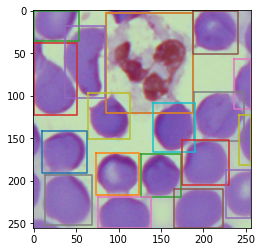

In [114]:
blood_cell_dataset.__show_img_annotated__(0)

In [51]:
#blood_cell_dataset.__show_img_annotated__(6)

In [50]:
#img, label_matrix = blood_cell_dataset.__getitem__(6)
#bboxes = cellboxes_to_boxes(label_matrix.reshape(1,7,7,7))[0]
#plot_image(img.permute(1,2,0).to("cpu"), bboxes)

## Step 3 : Utils Functions

In [82]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
    plt.show()

def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 7)
    best_boxes = predictions[..., 3:7]
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :2].argmax(-1).unsqueeze(-1)
    best_confidence = predictions[..., 2].unsqueeze(-1)
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    print(out.shape)
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

## Build Network

In [53]:
Model_architecture = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 512, 1, 1),
    "M",
    (3, 1024, 1, 1),
    (3, 1024, 1, 1)
]

In [54]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.Leakyrelu = nn.LeakyReLU(0.001)
    def forward(self, x):
        return self.Leakyrelu(self.batchnorm(self.conv(x)))

In [55]:
class Net(nn.Module):
    def __init__(self, network_architecture, in_channels):
        super(Net, self).__init__()
        self.network_architecture = network_architecture
        self.in_channels = in_channels
        self.convLayers = self.convLayers_()
        
        self.fc1 = nn.Linear(7*7*1024, 1024)
        self.leakyrelu = nn.LeakyReLU(0.001)
        self.fc2 = nn.Linear(1024, 7*7*7)
        
    def convLayers_(self):
        layers = []
        for i in self.network_architecture:
            if type(i) == str:
                layers += [nn.MaxPool2d(2, stride=2)]
                
            elif type(i) == tuple:
                layers += [Block(self.in_channels, out_channels=i[1], kernel_size=i[0], stride=i[2], padding=i[3])]
                self.in_channels = i[1]
                
            elif type(i) == list:
                for _ in range(i[-1]):
                    layers += [Block(self.in_channels, out_channels=i[0][1], kernel_size=i[0][0], stride=i[0][2], padding=i[0][3])]
                    layers += [Block(in_channels=i[0][1], out_channels=i[1][1], kernel_size=i[1][0], stride=i[1][2], padding=i[1][3])]
                    self.in_channels = i[1][1]
        return nn.Sequential(*layers)

    
        
    def forward(self, x):
        x = self.convLayers(x)
        x = x.view(-1, 7*7*1024)
        x = self.fc1(x)
        x = self.leakyrelu(x)
        x = self.fc2(x) 
        return x

In [56]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [57]:
net = Net(network_architecture=Model_architecture, in_channels=3).to(device)

## utils

In [96]:
def Intersection_over_union(boxes_preds, boxes_labels):

    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def non_max_supression(bboxes,iou_threshold,threshold):
    print("in non_max_supression function")
    # predictions = [[class_id, probability, x1,y1,x2,y2],[],...]
    assert type(bboxes) == list
    print(np.shape(bboxes))
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []
    
    while bboxes:
        chosen_bbox = bboxes.pop(0)
        
        bboxes = [
                    box 
                    for box in bboxes
                    if box[0] != chosen_bbox[0]
                    or Intersection_over_union(
                    torch.tensor(chosen_bbox[2:]),
                    torch.tensor(box[2:])
                    ) < iou_threshold
                ]
        bboxes_after_nms.append(chosen_bbox)
    return bboxes_after_nms

In [97]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=1, C=2):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        exists_box = target[..., 2].unsqueeze(3)  # in paper this is Iobj_i
        
        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * predictions[..., 3:7]

        box_targets = exists_box * target[..., 3:7]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )
        # print("box_loss = ", box_loss)
        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = predictions[..., 2:3]

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 2:3]),
        )
        # print()
        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 2:3], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 2:3], start_dim=1),
        )
        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :2], end_dim=-2,),
            torch.flatten(exists_box * target[..., :2], end_dim=-2,),
        )
        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )
        return loss

In [60]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = Intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [61]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_supression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

## Training

In [62]:
from collections import Counter

In [64]:
IMG_SIZE = 224
LEARNING_RATE = 2e-5
BATCH_SIZE = 1 # 64 in original paper
EPOCHS = 100

In [65]:
blood_cell_dataset =  BloodCellDataset("archive/images", "archive/annotation.csv", 7, 2, 1)
train_loader = DataLoader(
    dataset=blood_cell_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

In [66]:
for epoch in range(EPOCHS):  
    print("[INFO] EPOCH ", epoch)
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = net(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        net.zero_grad()
        loss.backward()
        optimizer.step()
        
    pred_boxes, target_boxes = get_bboxes(
        train_loader, net, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Train mAP: {mean_avg_prec}")
    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

[INFO] EPOCH  0


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.049667030572891235
Mean loss was 81.40333805084228
[INFO] EPOCH  1


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.08297701179981232
Mean loss was 28.759710674285888
[INFO] EPOCH  2


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.07665100693702698
Mean loss was 23.523206548690794
[INFO] EPOCH  3


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.49it/s]

Train mAP: 0.09924180805683136
Mean loss was 22.90024206161499
[INFO] EPOCH  4


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.12080910801887512
Mean loss was 22.898495569229127
[INFO] EPOCH  5


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.15711413323879242
Mean loss was 21.442657175064088
[INFO] EPOCH  6


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.155935600399971
Mean loss was 21.904870796203614
[INFO] EPOCH  7


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.54it/s]

Train mAP: 0.18156251311302185
Mean loss was 23.194076938629152
[INFO] EPOCH  8


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.1728980988264084
Mean loss was 21.744820213317873
[INFO] EPOCH  9


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.61it/s]

Train mAP: 0.16090843081474304
Mean loss was 23.016320333480834
[INFO] EPOCH  10


  3%|██▍                                                                               | 3/100 [00:00<00:05, 19.10it/s]

Train mAP: 0.21686598658561707
Mean loss was 21.170345783233643
[INFO] EPOCH  11


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.62it/s]

Train mAP: 0.3009253144264221
Mean loss was 20.854812231063843
[INFO] EPOCH  12


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.3175489008426666
Mean loss was 20.05454089164734
[INFO] EPOCH  13


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.2625093460083008
Mean loss was 20.058759117126463
[INFO] EPOCH  14


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.48it/s]

Train mAP: 0.235841304063797
Mean loss was 20.46660511016846
[INFO] EPOCH  15


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.24113354086875916
Mean loss was 22.598593616485594
[INFO] EPOCH  16


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.68it/s]

Train mAP: 0.25468993186950684
Mean loss was 19.944111309051515
[INFO] EPOCH  17


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.54it/s]

Train mAP: 0.3680446445941925
Mean loss was 19.762829875946046
[INFO] EPOCH  18


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.2353295385837555
Mean loss was 19.63228413581848
[INFO] EPOCH  19


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.3229578137397766
Mean loss was 19.5515917301178
[INFO] EPOCH  20


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.86it/s]

Train mAP: 0.3776635527610779
Mean loss was 17.51242244720459
[INFO] EPOCH  21


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.25it/s]

Train mAP: 0.3766400218009949
Mean loss was 18.10280044555664
[INFO] EPOCH  22


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.38746410608291626
Mean loss was 17.8008882522583
[INFO] EPOCH  23


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.69it/s]

Train mAP: 0.3677961528301239
Mean loss was 17.8891565990448
[INFO] EPOCH  24


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.36047637462615967
Mean loss was 17.61871699333191
[INFO] EPOCH  25


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.413130521774292
Mean loss was 18.06309296607971
[INFO] EPOCH  26


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.24461647868156433
Mean loss was 15.881401300430298
[INFO] EPOCH  27


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.40652358531951904
Mean loss was 15.812259683609009
[INFO] EPOCH  28


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.86it/s]

Train mAP: 0.455000102519989
Mean loss was 16.2284113073349
[INFO] EPOCH  29


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.3917231857776642
Mean loss was 15.857244267463685
[INFO] EPOCH  30


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.41it/s]

Train mAP: 0.41356161236763
Mean loss was 15.638381929397584
[INFO] EPOCH  31


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.44633880257606506
Mean loss was 15.563881549835205
[INFO] EPOCH  32


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.46218985319137573
Mean loss was 15.203235054016114
[INFO] EPOCH  33


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.43298250436782837
Mean loss was 14.686326627731324
[INFO] EPOCH  34


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.75it/s]

Train mAP: 0.31514599919319153
Mean loss was 14.242629961967468
[INFO] EPOCH  35


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.54it/s]

Train mAP: 0.4576798379421234
Mean loss was 13.092362065315246
[INFO] EPOCH  36


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.5929884910583496
Mean loss was 12.492157378196715
[INFO] EPOCH  37


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.5771251916885376
Mean loss was 12.617670888900756
[INFO] EPOCH  38


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.83it/s]

Train mAP: 0.49354034662246704
Mean loss was 11.542427663803101
[INFO] EPOCH  39


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.4669704735279083
Mean loss was 11.187459511756897
[INFO] EPOCH  40


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.54it/s]

Train mAP: 0.5084996819496155
Mean loss was 10.876796336174012
[INFO] EPOCH  41


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.83it/s]

Train mAP: 0.3256347179412842
Mean loss was 10.755128264427185
[INFO] EPOCH  42


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.4989500045776367
Mean loss was 11.346378378868103
[INFO] EPOCH  43


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.83it/s]

Train mAP: 0.5725300908088684
Mean loss was 11.04164608001709
[INFO] EPOCH  44


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.610938549041748
Mean loss was 10.934716567993163
[INFO] EPOCH  45


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.54it/s]

Train mAP: 0.4631476104259491
Mean loss was 10.412054948806762
[INFO] EPOCH  46


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.26it/s]

Train mAP: 0.49137723445892334
Mean loss was 9.194598274230957
[INFO] EPOCH  47


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.5243348479270935
Mean loss was 9.38633629322052
[INFO] EPOCH  48


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.5772660970687866
Mean loss was 9.269188907146454
[INFO] EPOCH  49


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.4468868374824524
Mean loss was 9.074272367954254
[INFO] EPOCH  50


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.55it/s]

Train mAP: 0.7137647867202759
Mean loss was 8.665522341728211
[INFO] EPOCH  51


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.98it/s]

Train mAP: 0.5815042853355408
Mean loss was 8.68822952747345
[INFO] EPOCH  52


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.6748790740966797
Mean loss was 8.882819142341614
[INFO] EPOCH  53


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.5837792754173279
Mean loss was 8.152888140678407
[INFO] EPOCH  54


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.41it/s]

Train mAP: 0.5647099018096924
Mean loss was 7.686231815814972
[INFO] EPOCH  55


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.86it/s]

Train mAP: 0.6829884052276611
Mean loss was 7.786966528892517
[INFO] EPOCH  56


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.73it/s]

Train mAP: 0.6023938655853271
Mean loss was 8.556345460414887
[INFO] EPOCH  57


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.73it/s]

Train mAP: 0.47246554493904114
Mean loss was 8.358275229930877
[INFO] EPOCH  58


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.7626689672470093
Mean loss was 7.673061900138855
[INFO] EPOCH  59


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.48it/s]

Train mAP: 0.5311347246170044
Mean loss was 7.185941104888916
[INFO] EPOCH  60


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.69it/s]

Train mAP: 0.6330207586288452
Mean loss was 7.490182268619537
[INFO] EPOCH  61


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.73it/s]

Train mAP: 0.7192350625991821
Mean loss was 8.155874967575073
[INFO] EPOCH  62


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.7248152494430542
Mean loss was 7.376332204341889
[INFO] EPOCH  63


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.7111958861351013
Mean loss was 6.714130103588104
[INFO] EPOCH  64


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.73it/s]

Train mAP: 0.7793171405792236
Mean loss was 6.486056385040283
[INFO] EPOCH  65


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.4571561813354492
Mean loss was 6.06787180185318
[INFO] EPOCH  66


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.7818877696990967
Mean loss was 6.3222323250770565
[INFO] EPOCH  67


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.5974661707878113
Mean loss was 6.097167992591858
[INFO] EPOCH  68


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.48it/s]

Train mAP: 0.7856469750404358
Mean loss was 6.352469615936279
[INFO] EPOCH  69


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.93it/s]

Train mAP: 0.5281033515930176
Mean loss was 6.029267144203186
[INFO] EPOCH  70


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.86it/s]

Train mAP: 0.6973608136177063
Mean loss was 5.490250060558319
[INFO] EPOCH  71


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.86it/s]

Train mAP: 0.7930008172988892
Mean loss was 5.417680306434631
[INFO] EPOCH  72


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.73it/s]

Train mAP: 0.4583221971988678
Mean loss was 5.66629647731781
[INFO] EPOCH  73


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.60it/s]

Train mAP: 0.6190149784088135
Mean loss was 6.0644999551773076
[INFO] EPOCH  74


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.00it/s]

Train mAP: 0.5229386687278748
Mean loss was 6.212064616680145
[INFO] EPOCH  75


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.54it/s]

Train mAP: 0.7788983583450317
Mean loss was 6.17298234462738
[INFO] EPOCH  76


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.7491244077682495
Mean loss was 6.089847671985626
[INFO] EPOCH  77


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.69it/s]

Train mAP: 0.6663609743118286
Mean loss was 5.237326914072037
[INFO] EPOCH  78


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.7583728432655334
Mean loss was 5.064419206380844
[INFO] EPOCH  79


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.8265852928161621
Mean loss was 5.31832335472107
[INFO] EPOCH  80


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.8334444165229797
Mean loss was 4.967789163589478
[INFO] EPOCH  81


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.7076977491378784
Mean loss was 4.843055952787399
[INFO] EPOCH  82


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.8241754174232483
Mean loss was 5.206167230606079
[INFO] EPOCH  83


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.7721021771430969
Mean loss was 5.091834937334061
[INFO] EPOCH  84


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.6187945604324341
Mean loss was 5.433585467338562
[INFO] EPOCH  85


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.8512269258499146
Mean loss was 5.477648055553436
[INFO] EPOCH  86


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.820493757724762
Mean loss was 4.933318004608155
[INFO] EPOCH  87


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.7036113739013672
Mean loss was 4.679384405612946
[INFO] EPOCH  88


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.7354308366775513
Mean loss was 4.451045926809311
[INFO] EPOCH  89


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.827049970626831
Mean loss was 3.9661812388896944
[INFO] EPOCH  90


  3%|██▍                                                                               | 3/100 [00:00<00:05, 18.63it/s]

Train mAP: 0.8266832828521729
Mean loss was 4.195537301301957
[INFO] EPOCH  91


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.13it/s]

Train mAP: 0.8371590375900269
Mean loss was 5.3102252840995785
[INFO] EPOCH  92


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.27it/s]

Train mAP: 0.7503499388694763
Mean loss was 4.876528285741806
[INFO] EPOCH  93


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.7499222755432129
Mean loss was 4.86537458896637
[INFO] EPOCH  94


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.8363471627235413
Mean loss was 4.560218019485474
[INFO] EPOCH  95


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.40it/s]

Train mAP: 0.8301720023155212
Mean loss was 4.203431929349899
[INFO] EPOCH  96


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.60it/s]

Train mAP: 0.8028526306152344
Mean loss was 4.780976005792618
[INFO] EPOCH  97


  3%|██▍                                                                               | 3/100 [00:00<00:04, 19.73it/s]

Train mAP: 0.6913877725601196
Mean loss was 4.481206820011139
[INFO] EPOCH  98


  3%|██▍                                                                               | 3/100 [00:00<00:04, 20.69it/s]

Train mAP: 0.7754313945770264
Mean loss was 5.008579112291336
[INFO] EPOCH  99


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.90it/s]


Train mAP: 0.8579474687576294
Mean loss was 4.453018505573272


## 

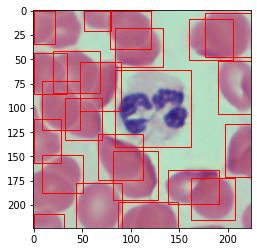

In [67]:
for x, y in train_loader:
    x = x.to(device)
    bboxes = cellboxes_to_boxes(y)[0]
    plot_image(x[0].permute(1,2,0).to("cpu"), bboxes)
    break

In [140]:
def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 7)
    best_boxes = predictions[..., 3:7]
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :2].argmax(-1).unsqueeze(-1)
    best_confidence = predictions[..., 2].unsqueeze(-1)
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

def cellboxes_to_boxes(out, S=7):
    print(out.shape)
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    print(converted_pred.shape)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    bboxes = []

    for bbox_idx in range(S * S):
        bboxes.append([x.item() for x in converted_pred[0, bbox_idx, :]])
    print(np.shape(bboxes))
    return bboxes

def non_max_supression(bboxes,iou_threshold,threshold):
    print("in non_max_supression function")
    # predictions = [[class_id, probability, x1,y1,x2,y2],[],...]
    assert type(bboxes) == list
    print(np.shape(bboxes))
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []
    
    while bboxes:
        chosen_bbox = bboxes.pop(0)
        
        bboxes = [
                    box 
                    for box in bboxes
                    if box[0] != chosen_bbox[0]
                    or Intersection_over_union(
                    torch.tensor(chosen_bbox[2:]),
                    torch.tensor(box[2:])
                    ) < iou_threshold
                ]
        bboxes_after_nms.append(chosen_bbox)
    return bboxes_after_nms

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(im)
    # Create a Rectangle potch
    for box in boxes:
        label = "rbc" if box[0] == 0 else "wbc"
        print(label)
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        center_x = upper_left_x * width + (box[2] * width)/2
        center_y = upper_left_y * height + (box[3] * height)/2
        plt.text(center_x, center_y, label, fontsize=9)

        ax.add_patch(rect)
    plt.show()

In [141]:
49*6

294

torch.Size([1, 343])
torch.Size([1, 49, 6])
(49, 6)
***** (49, 6)
in non_max_supression function
(49, 6)
(27, 6)
rbc
rbc
rbc
wbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc
rbc


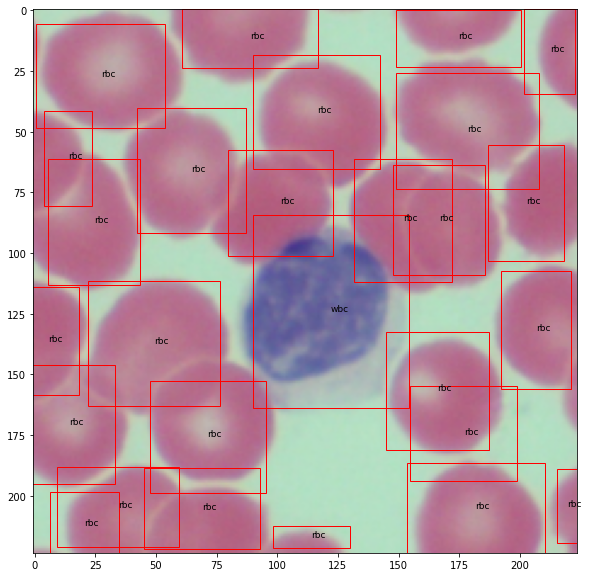

In [143]:
for x, y in train_loader:
    x = x.to(device)
    bboxes = cellboxes_to_boxes(net(x))
    print("*****", np.shape(bboxes))
    bboxes = non_max_supression(bboxes, iou_threshold=0.5, threshold=0.4)
    print(np.shape(bboxes))
    plot_image(x[0].permute(1,2,0).to("cpu"), bboxes)
    break

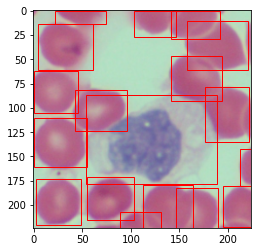

In [81]:
img, label_matrix = blood_cell_dataset.__getitem__(6)
bboxes = cellboxes_to_boxes(label_matrix.reshape(1,7,7,7))[0]
plot_image(img.permute(1,2,0).to("cpu"), bboxes)

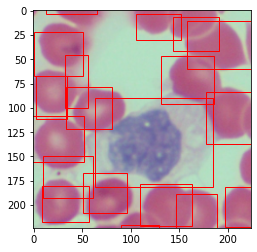

In [73]:
img, label_matrix = blood_cell_dataset.__getitem__(6)
out = net(img.reshape(-1, 3, 224, 224).to(device))
bboxes = cellboxes_to_boxes(out)[0]
bboxes = non_max_supression(bboxes, iou_threshold=0.3, threshold=0.3)
plot_image(img.permute(1,2,0).to("cpu"), bboxes)